In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import shutil
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [3]:
#!pip install --upgrade tensorflow


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# inicijalni podaci su organizovani po folderima koji predstavljaju podatke(fotografije) koje pripadaju osobama(pacijentima)
# unutar foldera za jednog pacijenta su dva foldera sa slikama iz klase 1 i 0
# podatke cemo organizovati tako sto cemo uzeti sve fotografije iz klase 0 za svakog pacijenta i skladistiti ih u jedan folder
# i analogno za fotografije iz klase 1
def create_data_path(base_path,input_path):
  try:
    os.makedirs(os.path.join(base_path,'data'))
    os.makedirs(os.path.join(base_path, 'data/0'))
    os.makedirs(os.path.join(base_path, 'data/1'))
  except:
    print("Greska pri kreiranju direktorijuma")

  list_dir=glob.glob(os.path.join(input_path,'*'))
    # data = np.array([])
    # y = np.array([])
  for id in list_dir:
    list_file_0=glob.glob(os.path.join(id,'0/*'))
    list_file_1= glob.glob(os.path.join(id, '1/*'))
    for file_0 in list_file_0:
      src_path = file_0
      dst_path = os.path.join(os.path.join(base_path, 'data/0'), os.path.basename(file_0))
      shutil.copy(src_path, dst_path)
             #np.append(data, np.array(Image.open(file_0)))
             #np.append(y, 0)

    for file_1 in list_file_1:
      src_path = file_1
      dst_path = os.path.join(os.path.join(base_path, 'data/1'), os.path.basename(file_1))
      shutil.copy(src_path, dst_path)
             #np.append(data, np.array(Image.open(file_1)))
             #np.append(y, 1)


In [6]:
#create_data_path('drive/MyDrive/collection/','drive/MyDrive/archive/data')

In [7]:
#list_dir_0=glob.glob(os.path.join('drive/MyDrive/collection/data/0/','*'))


In [8]:
#shape of images
# img = Image.open(list_dir_0[0])
# print("Shape of images: (",img.height,',', img.width,")")
# channel = 3


In [9]:
#print(len(list_dir_0))


In [10]:
K.image_data_format()

'channels_last'

In [11]:
# data0 = np.ndarray((len(list_dir_0), img.height, img.width, channel), dtype=np.float32)

# i=0
# for fname in list_dir_0:
#     curr_img = Image.open(fname)
#     if curr_img.size == img.size:
#         data0[i] = curr_img
#         i+=1




In [12]:
# list_dir_1=glob.glob(os.path.join('drive/MyDrive/collection/data/1/','*'))


In [13]:
# print(len(list_dir_1))


In [14]:
# img = Image.open(list_dir_1[0])
# print("Shape of images: (",img.height,',', img.width,")")
# channel = 3


In [15]:
# data1 = np.ndarray((len(list_dir_1), img.height, img.width, channel), dtype=np.float32)

# i=0
# for fname in list_dir_1:
#     curr_img = Image.open(fname)
#     if curr_img.size == img.size:
#         data1[i] = curr_img
#         i+=1


In [16]:
# print("Ukupan broj podataka ", len(list_dir_0)+len(list_dir_1))

In [17]:
# print("Broj podataka sa pozitivnim IDC-om ", len(data1))
# print("Broj podataka sa negativnim IDC-om ", len(data0))

In [18]:
# obradjene fotografije zelimo da sacuvamo u .npy fajlu u vidu nizova ne bi li ih lakse pokupili
# np.save('drive/MyDrive/collection/data0.npy', data0)


In [19]:
# obradjene fotografije zelimo da sacuvamo u .npy fajlu u vidu nizova ne bi li ih lakse pokupili
# np.save('drive/MyDrive/collection/data1.npy', data1)

In [20]:
#ucitavanje podataka iz npy fajla

np.load.__defaults__=(None, True, True, 'ASCII')
X0 = np.load('drive/MyDrive/collection/data0.npy')
np.load.__defaults__=(None, False, True, 'ASCII')



In [21]:
np.load.__defaults__=(None, True, True, 'ASCII')
X1 = np.load('drive/MyDrive/collection/data1.npy')
np.load.__defaults__=(None, False, True, 'ASCII')


In [22]:
#shape of images
img = X0[0]
print("Shape of image")
print(img.shape)
channel = 3

Shape of image
(50, 50, 3)


In [23]:
print("Broj podataka sa pozitivnim IDC-om ", len(X1))
print("Broj podataka sa negativnim IDC-om ", len(X0))
print("Ukupan broj podataka ", len(X0)+len(X1))

Broj podataka sa pozitivnim IDC-om  5717
Broj podataka sa negativnim IDC-om  18890
Ukupan broj podataka  24607


In [24]:
print(X1.shape)
print(X0.shape)

(5717, 50, 50, 3)
(18890, 50, 50, 3)


In [25]:
# pravimo i y0 i y1 na osnovu broja instanci jedne i druge klase
y0 = np.zeros(shape=(len(X0),1))
y1 = np.ones(shape=(len(X1),1))

In [26]:
#odvojicemo 50 % podataka za train, 20% za validaciju i 30% za test i iz skupa X0 i iz skupa X1
size_of_X0_train = int(len(X0) * 0.5)
size_of_X0_val = int(len(X0) * 0.2)


X0_train = X0[:size_of_X0_train]
X0_val = X0[size_of_X0_train : (size_of_X0_train+size_of_X0_val)]
X0_test = X0[(size_of_X0_train+size_of_X0_val) : ]

y0_train =y0[:size_of_X0_train]
y0_val = y0[size_of_X0_train : (size_of_X0_train+size_of_X0_val)]
y0_test = y0[(size_of_X0_train+size_of_X0_val) : ]



In [27]:
size_of_X1_train = int(len(X1) * 0.5)
size_of_X1_val = int(len(X1) * 0.2)

X1_train = X1[:size_of_X1_train]
X1_val = X1[size_of_X1_train : (size_of_X1_train+size_of_X1_val)]
X1_test = X1[(size_of_X1_train+size_of_X1_val) : ]

y1_train = y1[:size_of_X1_train]
y1_val = y1[size_of_X1_train : (size_of_X1_train+size_of_X1_val)]
y1_test = y1[(size_of_X1_train+size_of_X1_val) : ]


In [28]:
# sada cemo podeljene podatke po skupovima, objediniti po klasama, da bi imali skupove train test i val sa podacima iz obe klase
X_train = np.concatenate((X0_train, X1_train))
X_test =  np.concatenate((X0_test, X1_test))
X_val =  np.concatenate((X0_val, X1_val))
print(len(X_train)+len(X_test)+len(X_val))
print(len(X_train))

24607
12303


In [29]:
# slicno radimo i za y
y_train = np.concatenate((y0_train, y1_train))
y_test =  np.concatenate((y0_test, y1_test))
y_val =  np.concatenate((y0_val, y1_val))
print(len(y_train)+len(y_test)+len(y_val))

24607


In [30]:
#normalizacija - svodimo vrednosti pojedicnacnih piksela na vrednost iz intervala [0, 1]
X_train_norm = X_train/255
X_test_norm = X_test/255
X_val_norm = X_val/255


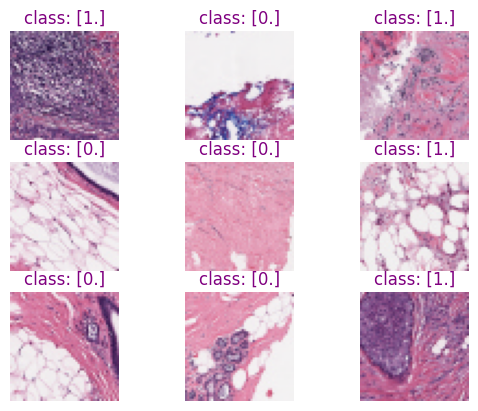

In [31]:
from numpy.random import seed
#iscrtavanje i analiza nekih podataka
# izmesacemo podatke pre nego sto ih budemo iscrtali da bi videli primere iz obe klase
perm_array = np.arange(len(X_train_norm))
np.random.shuffle(perm_array)
X_train_image_example = X_train_norm[perm_array]
y_train_image_example = y_train[perm_array]

i=0
for image in X_train_image_example[:9]:
        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.title(label=f"class: %s" % str(y_train_image_example[i]), color="purple")
        plt.axis('off')
        i+=1


[]

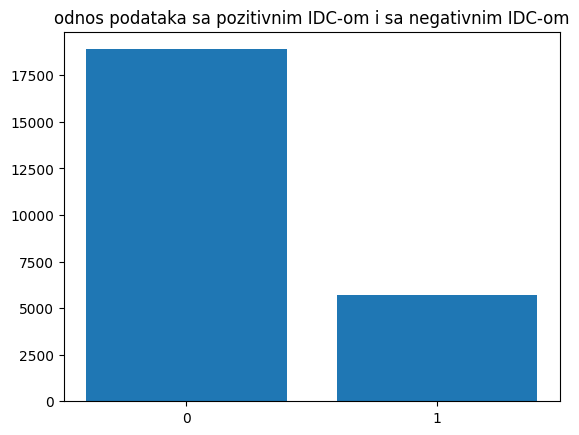

In [32]:
# odnos pozitivno klasifikovanih i negativno klasifikovanih slika
plt.title('odnos podataka sa pozitivnim IDC-om i sa negativnim IDC-om')
plt.bar([0, 1], [len(X0), len(X1)])
plt.xticks([0, 1])
plt.plot()
# mozemo zakljuciti da su podaci neizbalansirani,
# iz tog razloga iskoristicemo jednu od metoda koje resavaju ovaj problem,
# koristicemo metod ansambla - bagging (prosta agregacija)
# metod podrazumeva obucavanje veceg broja modela  (u nasem slucaju imacemo 3 modela posto je takav odnos
# podataka razlicitih klasa)
# snaga ovakvog modela poˇciva na ideji da ce se prilikom agregacije greske koje modeli nezavisno prave ponistiti
# U nasem slucaju imamo 5717 instanci manjinske klase i 18890 instanci većinske klase, možemo napraviti 3
# skupa podataka sa po 5717 instanci manjinske klase i oko 6000 instanci većinske klase. Na svakom od ovih skupova se može naučiti
# poseban model, a kao konačna ocena se može iskoristiti princip većinskog glasanja za odlučivanje o finalnom obeležju nove instance.


In [33]:
# posto ne mozemo koristiti ugradjenu klasu za Bagging jer kao bazni model ne podrzava model CNN,
# ovako nesto cemo uraditi pesaka korak po korak
# iz tog razloga nam je  potrebno da sami podelimo X_train na 3 priblizno obimna skupa
# za train skup koristimo manje podataka pa cemo podelu vrsiti u odnosu na te podatke
print(f"Skup train podataka je velicine: %d" % len(X_train_norm))
print(f"Odnos klasa je %s "% str(len(X0_train)/len(X1_train)))
# njihov odnos je lepo rasporedjen kao i kod celokupnog skupa podataka ~~ 3,3
# iz tog razloga odlucili smo se da imamo 3 modela

Skup train podataka je velicine: 12303
Odnos klasa je 3.3047585724282715 


In [34]:
# 12303/3 ~~ 4000
# kao prvi train skup uzecemo 4000 podataka, kao drugi isto 4000, a kao treci cemo uzeti ostatak od 4303
# pre toga cemo ponovo izmesati podatke
perm_array = np.arange(len(X_train_norm))
np.random.seed(9)
np.random.shuffle(perm_array)
X_train = X_train_norm[perm_array]
y_train = y_train[perm_array]

X_train1 = X_train[:4000]
X_train2 = X_train[4000:8000]
X_train3 = X_train[8000:]

y_train1 = y_train[:4000]
y_train2 = y_train[4000:8000]
y_train3 = y_train[8000:]

print(len(X_train1))
print(len(X_train2))
print(len(X_train3))
print(len(y_train1))
print(len(y_train2))
print(len(y_train3))

4000
4000
4303
4000
4000
4303


In [35]:
#promesacemo sada i validacioni i test skup
perm_array = np.arange(len(X_val_norm))
np.random.seed(9)
np.random.shuffle(perm_array)
X_val_shuffle = X_val_norm[perm_array]
y_val_shuffle = y_val[perm_array]

perm_array = np.arange(len(X_test_norm))
np.random.seed(9)

np.random.shuffle(perm_array)
X_test_shuffle = X_test_norm[perm_array]
y_test_shuffle = y_test[perm_array]
#print(np.all(y_test_shuffle==0))

In [36]:
batch_size = 128
epochs = 30

In [37]:
# ovaj model cemo koristiti kod Bagging-a metode za resavanje nebalansiranosti
def defOfModel(input_shape, X_train, y_train, batch_size, ep=30):
  model = Sequential ([
    Input(shape = input_shape),
    Conv2D(filters = 32, kernel_size = (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'),
    Conv2D(filters = 32, kernel_size = (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])
  model.summary()
  model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate=0.0002), metrics = ['accuracy'])

  batch_size = 128
  history = model.fit(X_train, y_train,
                      validation_split=0.15,
                      batch_size=batch_size,
                      epochs=ep,
                      verbose=1)
  return model, history


In [38]:
# ovaj model ce koristiti tezinu instanci da bi resio problem nebalansiranosti
def defOfModelWithClassWeight(input_shape, X_train, y_train, batch_size, ep=30):
  model = Sequential ([
    Input(shape = input_shape),
    Conv2D(filters = 32, kernel_size = (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'),
    Conv2D(filters = 32, kernel_size = (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'),
    Conv2D(filters = 64, kernel_size = (3, 3), strides = (2, 2), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dropout(0.3),
    Dense(1, activation = 'sigmoid')
])
  model.summary()
  model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate=0.0002), metrics = ['accuracy'])

  batch_size = 128
  history = model.fit(X_train, y_train,
                      validation_split=0.15,
                      batch_size=batch_size,
                      epochs=ep,
                      verbose=1, class_weight={0:0.5, 1: 0.5})
  return model, history


In [39]:
# iscrtavanje grafika za metrike loss i accuracy po epohama
def graphOfLossAndAccuracy(history):
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
  plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
  plt.legend(loc='best')
  #plt.ylim(0,1)

  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
  plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
  plt.legend(loc='best')
  #plt.ylim(0,1)

  plt.show()

In [40]:
def modelEvaluate(model, X_test, y_test):
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  return (score[0], score[1])


In [41]:
model1, hist1 = defOfModel(img.shape, X_train1, y_train1, batch_size, epochs)
model2, hist2 = defOfModel(img.shape, X_train2, y_train2, batch_size, epochs)
model3, hist3 = defOfModel(img.shape, X_train3, y_train3, batch_size, epochs)
model, hist = defOfModelWithClassWeight(img.shape, X_train, y_train, batch_size, epochs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 6, 6, 32)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                        

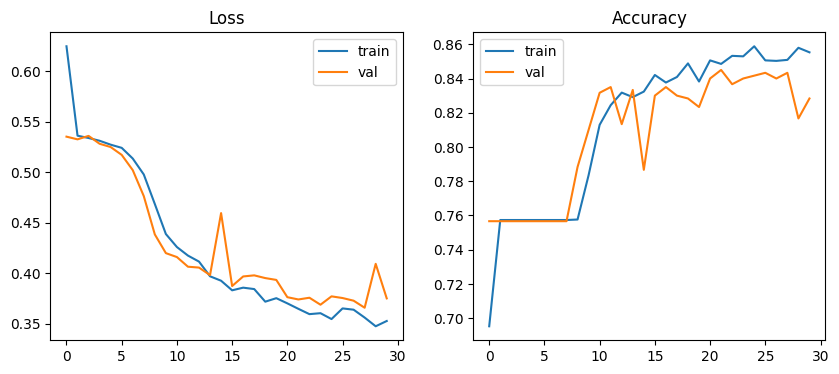

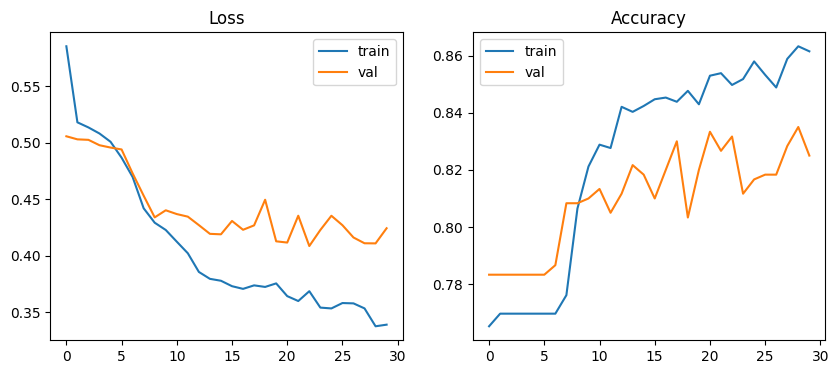

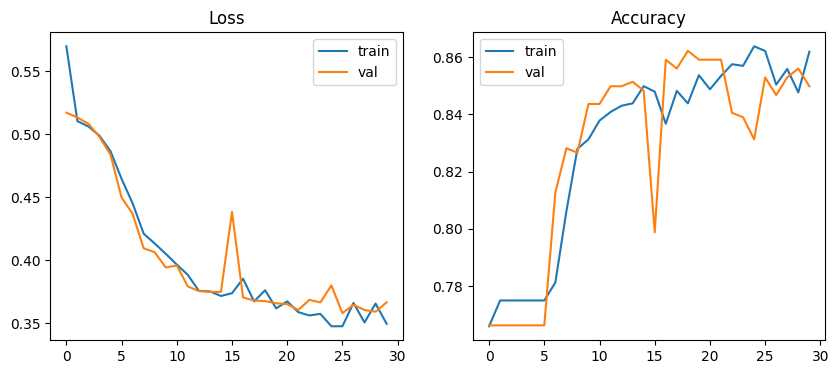

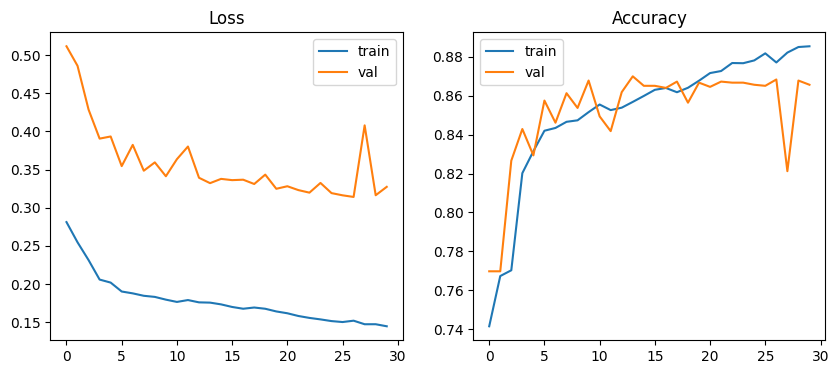

In [42]:
graphOfLossAndAccuracy(hist1)
graphOfLossAndAccuracy(hist2)
graphOfLossAndAccuracy(hist3)
graphOfLossAndAccuracy(hist)

In [43]:
# TO DO: iskomentarisi grafike

In [44]:
loss1, acc1 = modelEvaluate(model1, X_val_shuffle, y_val_shuffle)
loss2, acc2 = modelEvaluate(model2, X_val_shuffle, y_val_shuffle)
loss3, acc3 = modelEvaluate(model3,X_val_shuffle, y_val_shuffle)
print("---------------------------------------------")
print("Prosek metrika ova tri modela: loss = ",((loss1+loss2+loss3)/3.0),' , accuracy = ', ((acc1+acc2+acc3)/3.0))
print("---------------------------------------------")
loss, acc = modelEvaluate(model, X_val_shuffle, y_val_shuffle)

Test loss: 0.37377774715423584
Test accuracy: 0.84820157289505
Test loss: 0.31436264514923096
Test accuracy: 0.8784799575805664
Test loss: 0.29528000950813293
Test accuracy: 0.884982705116272
---------------------------------------------
Prosek metrika ova tri modela: loss =  0.3278068006038666  , accuracy =  0.8705547451972961
---------------------------------------------
Test loss: 0.2843635380268097
Test accuracy: 0.8866084218025208


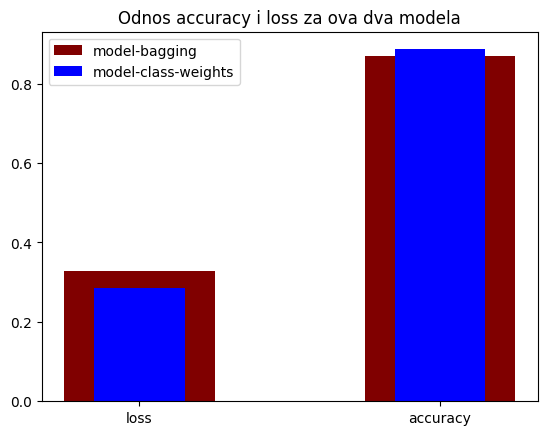

In [45]:
# mozemo se i graficki uveriti da su modeli po preciznosti i gubitku vrlo slicni i da za krajnju evaluaciju na test skupu u ovom primeru
# mozemo koristiti bilo koji od modela
plt.title("Odnos accuracy i loss za ova dva modela")
plt.bar(['loss','accuracy'], [((loss1+loss2+loss3)/3.0), ((acc1+acc2+acc3)/3.0)], color ='maroon',
        width = 0.5, label='model-bagging')
plt.bar(['loss','accuracy'], [loss, acc], color ='blue',
        width = 0.3, label='model-class-weights')
plt.legend(loc='best')
plt.show()

In [46]:
# posto se za nijansu bolje pokazao model sa , njtezinama instanci, nega cemo koristiti za krajnju evaluaciju na test skupu

In [60]:
#loss1, acc1 = modelEvaluate(model1, X_test_shuffle, y_test_shuffle)
#loss2, acc2 = modelEvaluate(model2, X_test_shuffle, y_test_shuffle)
#loss3, acc3 = modelEvaluate(model3, X_test_shuffle, y_test_shuffle)
loss, acc = modelEvaluate(model, X_test_shuffle, y_test_shuffle)

Test loss: 0.47495436668395996
Test accuracy: 0.828118622303009


In [61]:
#y_predicted1 = model1.predict(X_test_shuffle)
#y_predicted2 = model2.predict(X_test_shuffle)
#y_predicted3 = model3.predict(X_test_shuffle)
y_predicted = model.predict(X_test_shuffle) # ovaj model necemo koristiti za evaluaciju na test skupu

231/231 [==============================] - 3s 14ms/step


In [49]:
# s obzirom da su dobijene predikciji date kao niz realnih brojeva u opsegu [0, 1], u slucaju da je vrednost <0.5
# dodelicemo oznaku klase 0 inace oznaku klase 1
def inClasses(y_pred):
  i=0;
  res = []
  for el in y_pred:
    if el<0.5:
      res.append(0)
    else:
      res.append(1)
    i = i+1
  return res

In [72]:
#y_predicted1_in_classes = inClasses(y_predicted1)
#y_predicted2_in_classes = inClasses(y_predicted2)
#y_predicted3_in_classes = inClasses(y_predicted3)
y_predicted_in_classes = inClasses(y_predicted)

[0, 0, 0, 0, 1, 0, 0, 1, 0, 1]

In [66]:
# brojanje glasova u slucaju kada bismo koristili model sa bagging-om
# arrays = np.array([y_predicted1_in_classes,
#           y_predicted2_in_classes,
#           y_predicted3_in_classes])
# y_pred = arrays.sum(axis=0)

In [67]:
#  vecinsko glasanje u slucaju kada bismo koristili model sa bagging-om
# y_pred_final = []
# for y in y_pred:
#   if y>=2:
#     y_pred_final.append(1)
#   else:
#     y_pred_final.append(0)


In [68]:
#y_pred_final = np.array(y_pred_final)

In [69]:
y_test_final = y_test_shuffle.reshape(-1)


In [71]:
from sklearn.metrics import confusion_matrix, classification_report

#confusion_matrix_bagging = confusion_matrix(y_test_final, y_pred_final)
confusion_matrix = confusion_matrix(y_test_final, y_predicted_in_classes) # ovo bi bila matrica konfuzije za model koji nismo izabrali

In [73]:
print(confusion_matrix)

[[5381  286]
 [ 983  733]]


In [74]:
# mozemo primetiti da model daje nesto vise FP rezultata sto ukazuje na to da smo rekli da neki podatak ima pozitivan IDC (ukazuje na postojanje
# malignih celiija), iako ih nema, ali takav pristup u medicini je zasigurno bolji, jer bi se daljim ispitivanjem utvrdilo
# da je rec o laznom upozorenju (bolje nego naciniti propust druge vrste)

In [76]:
report_bagging = classification_report(y_test_shuffle, y_predicted_in_classes)

print(report_bagging)

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.89      5667
         1.0       0.72      0.43      0.54      1716

    accuracy                           0.83      7383
   macro avg       0.78      0.69      0.72      7383
weighted avg       0.82      0.83      0.81      7383



In [59]:
# cuvanje svih modela
model1.save('drive/MyDrive/models/bagging/model1.hdf5')
model2.save('drive/MyDrive/models/bagging/model2.hdf5')
model3.save('drive/MyDrive/models/bagging/model3.hdf5')

model.save('drive/MyDrive/models/model_class_weights.hdf5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
